# K-Means Clustering
## Manual VS Sklearn Implementation

The purpose of this notebook is to utilize unsupervised learning method K-means clustering to determine the different types of point guards that play in the NBA. Initially this will be done using a series of functions. The result will be compared with the sklearn implementation
Data located at http://www.nbastuffer.com/2013-2014_nba_regular_season_player_stats.html

In [312]:
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

nba = pd.read_csv("/Users/neilklenk/Documents/Datasets/nba.csv")
nba_2 = nba


Create a dictionary containing the cluster centroids. This will be updated with each recalculation

In [313]:
def dict_of_centroids(centroids):
    dictionary = dict()
    counter = 0
    for index, row in centroids.iterrows():
        coordinates = [row['ppg'], row['atr']]
        dictionary[counter] = coordinates
        counter += 1
    return(dictionary)

Detemine the euclidian distance between the centroids to determine which center they are closest to

In [314]:
def calculate_dist(centroid, player_vals):
    root_dist = 0
    for x in range(0, len(centroid)):
        difference = centroid[x] - player_vals[x]
        squared_diff = np.square(difference)
        root_dist += squared_diff
    euclid_dist = np.sqrt(root_dist)
    return(euclid_dist)

Assign each player to a cluster depending on their ppg and atr values

In [315]:
def assign_to_cluster(row):
    min_dist = 9999
    my_centroid = 0
    for centroid in centroids_dict:
        centroid_coord = centroids_dict[centroid]
        point_coord = [row['ppg'], row['atr']]
        dist = calculate_dist(centroid_coord, point_coord)
        if dist < min_dist:
            min_dist = dist
            my_centroid = centroid
    return(my_centroid)

recalculate the centroids so that they are at the average location of all of the points that currently belong to that cluster

In [316]:
def recalculate_centroids(df):
    new_centroids_dict = dict()
    for cluster_id in range(0, num_clusters):
        group_samples = df[df['cluster'] == cluster_id]
        x_cord = np.mean(group_samples['ppg'])
        y_cord = np.mean(group_samples['atr'])
        new_centroids_dict[cluster_id] = [x_cord, y_cord]
    return new_centroids_dict

Visualizing clusters

In [317]:
def visualize_clusters(df, num_clusters):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    #fig = plt.figure(figsize=(10,10))
    cluster_df = pd.DataFrame()
    #ax = fig.add_subplot(2,3,n+1)
    for n in range(num_clusters):
        cluster_df = df[df['cluster'] == n]
        ax.scatter(cluster_df['ppg'], cluster_df['atr'], c=colors[n-1])
    ax.set_xlabel('Points Per Game', fontsize=13)
    ax.set_ylabel('Assist Turnover Ratio', fontsize=13)
        
    return(ax)
    #plt.show()

Collecting all of the NBA players who are point guards, flitering out all of the point guards that have a turnover value of 0, and determining the asist turnover ratio of each remaining pointguard by dividing the number of assist that they have by the number of turnovers.

In [318]:
# Filter dataset so that only point guards are present
point_guards = nba[nba['pos'] == 'PG']

# Calculate the assist turnover ratio to use as a data point
point_guards = point_guards[point_guards['tov'] != 0]
point_guards['atr'] = point_guards['ast']/point_guards['tov']

### Manual implementation of Kmeans clustering

Initializing the values for the clustering centers

In [319]:
# randomly generate the first set of cluster centers
num_clusters = 5
# randomly select the indicies of 5 players 
init_cluster_centers = np.random.choice(point_guards.index, size=num_clusters)
print("init: ", init_cluster_centers);
# use the values of the players with those indicies as the starting points for the clusters
centroids = point_guards.loc[init_cluster_centers]
print("Centroids: ", centroids);
 
centroids_dict = dict_of_centroids(centroids)

init:  [383 241  86 403 451]
Centroids:              PLAYER TEAM pos  AGE  GP   MPG  MIN%  USG%    tov  FTA  \
383   Phil Pressey  Bos  PG   22  75  14.9  31.0  14.3  0.242   45   
241   Kyrie Irving  Cle  PG   21  71  35.0  71.8  28.3  0.121  338   
86   Dwight Buycks  Tor  PG   24  14  10.2  19.7  19.7  0.161    9   
403    Ricky Rubio  Min  PG   23  82  32.0  66.0  16.5  0.218  283   
451  Isaiah Thomas  Sac  PG   24  72  34.5  71.2  26.4  0.143  407   

        ...        TS%   ppg  RPG  TRB%  APG   ast   SPG   BPG   VI  \
383     ...      0.390   2.8  1.4   5.3  3.2  31.1  0.91  0.07  6.2   
241     ...      0.533  20.8  3.6   5.9  6.1  31.9  1.52  0.32  8.8   
86      ...      0.414   3.1  1.6   9.4  0.7  10.8  0.57  0.00  5.9   
403     ...      0.491   9.5  4.2   7.1  8.6  38.0  2.32  0.13  8.8   
451     ...      0.574  20.3  2.9   4.8  6.3  32.5  1.29  0.11  8.3   

            atr  
383  128.512397  
241  263.636364  
86    67.080745  
403  174.311927  
451  227.272727  

[5

In [320]:
# This creates the column, `cluster`, by applying assign_to_cluster row-by-row
point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)
point_guards_copy = point_guards

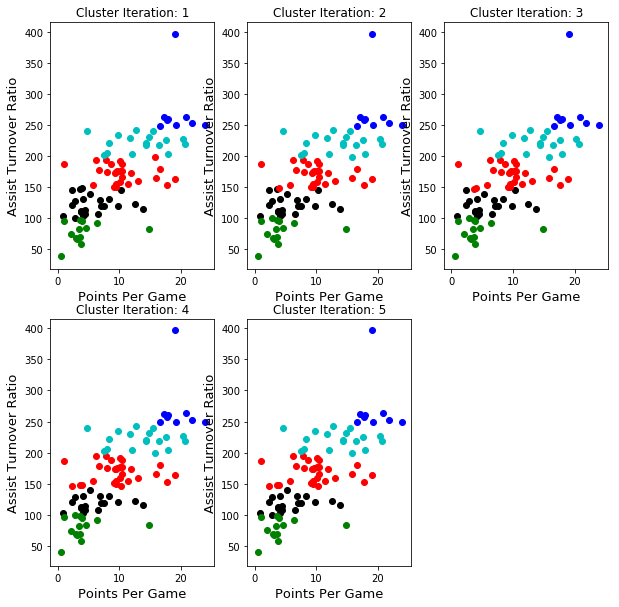

In [321]:
#display the clustering results for 5 iterations
fig = plt.figure(figsize=(10,10))
for i in range(5):
    centroids_dict = recalculate_centroids(point_guards);
    point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1);
    ax = fig.add_subplot(2,3,i+1)
    ax = visualize_clusters(point_guards, num_clusters);
    ax.set_title("Cluster Iteration: {}".format(i+1))

plt.show()
    



### Kmeans implementataion in sklearn

Where I had to have the previous code iterate a few times to ensure that the accurate clusters were represented, this is not necessary when implementing K-means clustering with Sklearn. Sklearn re rund the entire clustering process many times with many random initial centroids. This ensures that the final results are less bias towards the centroids selected during the initial passthrough

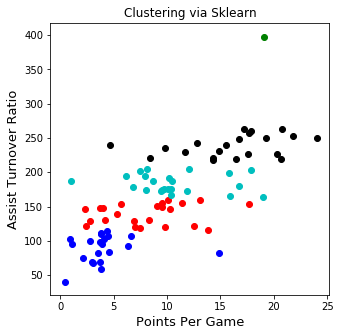

In [333]:
point_guards = point_guards_copy.reset_index()
fig, ax = plt.subplots(figsize=(5,5))

kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(point_guards[['ppg', 'atr']])
point_guards['cluster'] = kmeans.labels_
centroids = kmeans.cluster_centers_

ax.set_title("Clustering via Sklearn")
ax = visualize_clusters(point_guards, num_clusters);


plt.show()



Clustering both manually and using the Sklearn library resulted in very similar results. The Kmeans functions within Sklearn are more production ready, and computationally less expensive than doing it by hand. However, this is a good exercise to see what is going on behind the scenes. 